In [0]:
import argparse
import torch
torch.manual_seed(0)
from torch import optim
from torchvision import transforms
import os
import os.path as osp
from tqdm import tqdm_notebook
from PIL import Image
import PIL

**ACCESS TO THE DRIVE FOLDER WHERE THE DATASET HAS BEEN STORED**

In [10]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Final project AIDL/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**DEFINE ARGUMENTS**

In [0]:
class Args:

    frontal_images_directories = "gdrive/My Drive/Final project AIDL/dataset-cfp/Protocol/image_list_F.txt"
    profile_images_directories = "gdrive/My Drive/Final project AIDL/dataset-cfp/Protocol/image_list_P.txt"
    split_main_directory = "gdrive/My Drive/Final project AIDL/dataset-cfp/Protocol/Split"
    split_traindata = ["01", "02", "03", "04", "05", "06"]
    split_valdata = ["07", "08"]
    split_testdata = ["09", "10"]
    dataset_root = "gdrive/My Drive/Final project AIDL"
    dataset= "CFPDataset"
    lr = float(5e-4)
    weight_decay = float(0.05)
    momentum = float(0.9)
    batch_size = int(16)
    workers = int(8)
    start_epoch = int(0)
    epochs = int(20)
    resume = ""


**CREATE DATASET CLASS**

In [0]:
import numpy as np
import torch
import torchvision
import os.path as osp
from pathlib import Path
from torch.utils.data import dataset
from PIL import Image


class CFPDataset(dataset.Dataset):
    def __init__(self, path, args, img_transforms=None, dataset_root="",
                 split="train", input_size=(224, 224)):
        super().__init__()

        self.data = []
        self.split = split

        self.load(path, args)

        print("Dataset loaded")
        print("{0} samples in the {1} dataset".format(len(self.data),
                                                      self.split))
        self.transforms = img_transforms
        self.dataset_root = dataset_root
        self.input_size = input_size

    def load(self, path, args):

        # read directories for frontal images
        lines = open(args.frontal_images_directories).readlines()
        idx = 0
        directories_frontal_images = []
        while idx < len(lines):
            x = lines[idx].strip().split()
            directories_frontal_images.append(x)
            idx += 1

        # read directories for profile images
        lines = open(args.profile_images_directories).readlines()
        idx = 0
        directories_profile_images = []
        while idx < len(lines):
            x = lines[idx].strip().split()
            directories_profile_images.append(x)
            idx += 1

        # read same and different pairs of images and save at dictionary
        self.data = []
        for i in path:
            ff_diff_file = osp.join(args.split_main_directory, 'FF', i,
                                    'diff.txt')
            lines = open(ff_diff_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                img1_dir = directories_frontal_images[int(img_pair[0])-1][1]
                img2_dir = directories_frontal_images[int(img_pair[1])-1][1]
                pair_tag = 0.0
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                self.data.append(d)
                idx += 1

            ff_same_file = osp.join(args.split_main_directory, 'FF', i,
                                    'same.txt')
            lines = open(ff_same_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                img1_dir = directories_frontal_images[int(img_pair[0])-1][1]
                img2_dir = directories_frontal_images[int(img_pair[1])-1][1]
                pair_tag = 1.0
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                self.data.append(d)
                idx += 1

            fp_diff_file = osp.join(args.split_main_directory, 'FP', i,
                                    'diff.txt')
            lines = open(fp_diff_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                img1_dir = directories_frontal_images[int(img_pair[0])-1][1]
                img2_dir = directories_profile_images[int(img_pair[1])-1][1]
                pair_tag = 0.0
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                self.data.append(d)
                idx += 1

            fp_same_file = osp.join(args.split_main_directory, 'FP', i,
                                    'same.txt')
            lines = open(fp_same_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                img1_dir = directories_frontal_images[int(img_pair[0])-1][1]
                img2_dir = directories_profile_images[int(img_pair[1])-1][1]
                pair_tag = 1.0
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                self.data.append(d)
                idx += 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        d = self.data[index]
        image1_path = osp.join(self.dataset_root, 'dataset-cfp', d[
            'img1_path'])
        image2_path = osp.join(self.dataset_root, 'dataset-cfp', d[
            'img2_path'])
        image1 = Image.open(image1_path).convert('RGB')
        image2 = Image.open(image2_path).convert('RGB')
        tag = d['pair_tag']
        if self.transforms is not None:
            # this converts from (HxWxC) to (CxHxW) as well
            img1 = self.transforms(image1)
            img2 = self.transforms(image2)

        return img1, img2, tag

In [0]:
from torch.utils import data

def get_dataloader(datapath, args, img_transforms=None, split="train"):

    data_loader = data.DataLoader(CFPDataset(datapath,
                                             args,
                                             split=split,
                                             img_transforms=img_transforms,
                                             dataset_root=osp.expanduser(
                                                 args.dataset_root)),
                                  batch_size=args.batch_size,
                                  shuffle=True,
                                  num_workers=args.workers,
                                  pin_memory=True,
                                  drop_last=True)
    return data_loader

**DEFINE THE MODEL**

In [0]:
import torch
from torch import nn
from torchvision.models import vgg16_bn


class RecognitionModel(nn.Module):
    """
    Siamese network
    """
    def __init__(self):
        super().__init__()

        self.feat = vgg16_bn(pretrained=True).features
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=512*7*7*2, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5)
        )
        self.fc2 = nn.Linear(in_features=4096, out_features=2)

    def forward(self, img1, img2):
        # the input to the vgg16 is a fixed-size 224x224 RGB image
        # we get the vgg16 features
        feat_1 = self.feat(img1)
        feat_2 = self.feat(img2)
        feat_1 = feat_1.view(feat_1.size(0), -1)
        feat_2 = feat_2.view(feat_2.size(0), -1)
        # we concatenate the two tensors of features
        feat = torch.cat((feat_1, feat_2), 1)
        # we run the classifier
        feat_3 = self.fc1(feat)
        tag = self.fc2(feat_3)
        return tag


**LOSS**

In [0]:
from torch import nn

class RecognitionCriterion(nn.Module):
    def __init__(self):
        super().__init__()
        self.classification_criterion = nn.CrossEntropyLoss()
        self.cls_loss = None

    def forward(self, *input):
        self.cls_loss = self.classification_criterion(*input)
        return self.cls_loss

**TRAINING AND VALIDATION**

In [0]:
import torch
from torchvision import transforms
from torch.nn import functional as nnfunc
import numpy as np

def accuracy(predictions, y):
    correct = 0
    total = 0
    preds = torch.topk(predictions, k=1)
    for p, i, label in zip(preds[0], preds[1], y):
        total += 1
        if i == label:
            correct += 1
    return correct/total

def train(model, loss_fn, optimizer, dataloader, epoch, device):
    model = model.to(device)
    model.train()
    all_loss = []
    all_acc = []
        
    for idx, (img1, img2, prob) in enumerate(dataloader):
        x1 = img1.float().to(device)
        x2 = img2.float().to(device)
        optimizer.zero_grad()
        prob_t = prob.to(torch.long)
        #prob_t = prob.type(torch.FloatTensor)
        prob_var = prob_t.to(device)
        #prob_var = prob.to(device)
        #prob_var = prob_var.unsqueeze(dim=1)
        
        output = model(x1, x2)
        #output = output.reshape(1, -1)
        #output = output.squeeze()
        
        loss = loss_fn(output, prob_var)
        all_loss.append(loss.item())
        acc = accuracy(output, prob_var)
        all_acc.append(acc) 
        
        loss.backward()
        optimizer.step()
        
            
        if idx % 14 == 0:
            message1 = "TRAIN Epoch [{0}]: [{1}/{2}] ".format(epoch, idx,
                                                              len(dataloader))
            message2 = "Loss: [{0:.4f}]; Accuracy: [{1}]".format(loss.item(),
                                                                acc)
            print(message1, message2)
    
    return all_loss, all_acc

def val(model, loss_fn, dataloader, epoch, device):
    model = model.to(device)
    all_loss = []
    all_acc =[]
    
    for idx, (img1, img2, prob) in enumerate(dataloader):
        x1 = img1.float().to(device)
        x2 = img2.float().to(device)
        
        prob_t = prob.to(torch.long)
        #prob_t = prob.type(torch.FloatTensor)
        prob_var = prob_t.to(device)
        # prob_var = prob.to(device)
        #prob_var = prob_var.unsqueeze(dim=1)
        output = model(x1, x2)
        #output = output.reshape(1, -1)
        #output = output.squeeze()
        loss = loss_fn(output, prob_var)
        acc = accuracy(output, prob_var)
        all_loss.append(loss.item())
        all_acc.append(acc)
                
        if idx % 14 == 0:
            message1 = "VAL Epoch [{0}]: [{1}/{2}] ".format(epoch, idx,
                                                              len(dataloader))
            message2 = "Loss: [{0:.4f}]; Accuracy: [{1}]".format(loss.item(), acc)
            print(message1, message2)
    return all_loss, all_acc

In [0]:
# add data augmentation
args = Args()
data_aug = True
train_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

if data_aug == True:
  train_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                        transforms.RandomHorizontalFlip(), 
                                        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR), 
                                        transforms.ToTensor()])

img_transforms = train_transform


**LOAD DATASET**

In [20]:
train_loader = get_dataloader(args.split_traindata, args,
                              img_transforms=img_transforms)

Dataset loaded
8400 samples in the train dataset


In [21]:
val_loader = get_dataloader(args.split_valdata, args,
                            img_transforms=img_transforms, split="val")

Dataset loaded
2800 samples in the val dataset


In [0]:
model = RecognitionModel().cuda()
loss_fn = RecognitionCriterion()

In [0]:
# check for CUDA
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [0]:
# define optimizer
optimizer = optim.SGD(model.parameters(), lr=args.lr,
                      momentum=args.momentum, weight_decay=args.weight_decay)
# optimizer = optim.ADAM(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

In [0]:
#if args.resume:
#    checkpoint = torch.load(args.resume)
#    model.load_state_dict(checkpoint['model'])
#    optimizer.load_state_dict(checkpoint['optimizer'])
#    # Set the start epoch if it has not been
#    if not args.start_epoch:
#        args.start_epoch = checkpoint['epoch']
#
#def save_checkpoint(state, filename="checkpoint.pth", save_path="weights"):
#    # check if the save directory exists
#    if not Path(save_path).exists():
#        Path(save_path).mkdir()
#
#    save_path = Path(save_path, filename)
#    torch.save(state, str(save_path))

**MAIN**

In [0]:
check_point_name = 'gdrive/My Drive/Final project AIDL/results/best_epoch.pth.tar'
# train and evalute for `epochs`
loss_epoch_train = []
loss_epoch_val = []
acc_epoch_train = []
acc_epoch_val = []
best_acc = 0
for epoch in range(args.start_epoch, args.epochs):
    # scheduler.step()
    train_loss, train_acc = train(model, loss_fn, optimizer, train_loader, epoch, device=device)
    
    av_loss = np.mean(train_loss)
    av_acc = np.mean(train_acc)
    loss_epoch_train.append(av_loss)
    acc_epoch_train.append(av_acc)
    
    val_loss, val_acc = val(model, loss_fn, val_loader, epoch, device=device)
    
    av_loss = np.mean(val_loss)
    av_acc = np.mean(val_acc)
    loss_epoch_val.append(av_loss)
    acc_epoch_val.append(av_acc)
    
    if av_acc > best_acc:
        best_acc = av_acc
        best_epoch = epoch
        
        checkpoint = {
            'epoch': epoch,
            'batch_size': train_loader.batch_size,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        
        torch.save(checkpoint, check_point_name)
        # save epoch weights with highest validation accuracy
    
    save_epochs = {
        'loss_epoch_train': loss_epoch_train,
        'loss_epoch_val': loss_epoch_val,
        'acc_epoch_train': acc_epoch_train,
        'acc_epoch_val': acc_epoch_val
    }
    
    torch.save(save_epochs, 'gdrive/My Drive/Final project AIDL/results/loss_acc_per_epoch')
        
print("Best Epoch: ",best_epoch, "Best Acc: ", best_acc)

TRAIN Epoch [0]: [0/525]  Loss: [0.6941]; Accuracy: [0.5625]
TRAIN Epoch [0]: [14/525]  Loss: [0.6635]; Accuracy: [0.75]
TRAIN Epoch [0]: [28/525]  Loss: [0.6707]; Accuracy: [0.5625]
TRAIN Epoch [0]: [42/525]  Loss: [0.6655]; Accuracy: [0.75]
TRAIN Epoch [0]: [56/525]  Loss: [0.7031]; Accuracy: [0.5]
TRAIN Epoch [0]: [70/525]  Loss: [0.7329]; Accuracy: [0.375]
TRAIN Epoch [0]: [84/525]  Loss: [0.6610]; Accuracy: [0.6875]
TRAIN Epoch [0]: [98/525]  Loss: [0.6782]; Accuracy: [0.5625]
TRAIN Epoch [0]: [112/525]  Loss: [0.6841]; Accuracy: [0.5625]
TRAIN Epoch [0]: [126/525]  Loss: [0.6825]; Accuracy: [0.5625]
TRAIN Epoch [0]: [140/525]  Loss: [0.7410]; Accuracy: [0.3125]
TRAIN Epoch [0]: [154/525]  Loss: [0.7045]; Accuracy: [0.5]
TRAIN Epoch [0]: [168/525]  Loss: [0.7276]; Accuracy: [0.5]
TRAIN Epoch [0]: [182/525]  Loss: [0.6951]; Accuracy: [0.5]
TRAIN Epoch [0]: [196/525]  Loss: [0.6392]; Accuracy: [0.6875]
TRAIN Epoch [0]: [210/525]  Loss: [0.7380]; Accuracy: [0.3125]
TRAIN Epoch [0]: [

KeyboardInterrupt: ignored

**PLOT RESULTS**

In [11]:
loss_acc_per_epoch=torch.load('gdrive/My Drive/Final project AIDL/results/loss_acc_per_epoch')
#print(len(loss_acc_per_epoch['loss_epoch_val']))
#print(max(loss_acc_per_epoch['acc_epoch_val']))

24
0.7289285714285715


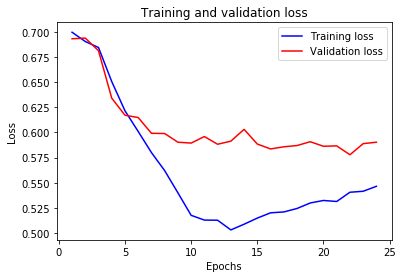

In [7]:
import matplotlib.pyplot as plt
epochs = range(1, len(loss_acc_per_epoch['loss_epoch_train']) + 1)
# b is for "solid blue line"
plt.plot(epochs, loss_acc_per_epoch['loss_epoch_train'], 'b', label='Training loss')
# r is for "solid red line"
plt.plot(epochs, loss_acc_per_epoch['loss_epoch_val'], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('gdrive/My Drive/Final project AIDL/results/train_val_loss.png')
plt.show()

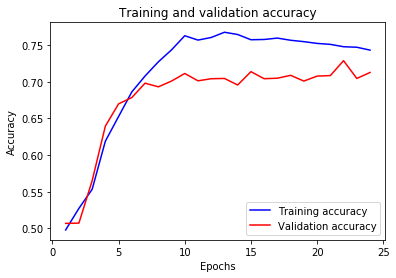

In [8]:
epochs = range(1, len(loss_acc_per_epoch['acc_epoch_train']) + 1)
# b is for "solid blue line"
plt.plot(epochs, loss_acc_per_epoch['acc_epoch_train'], 'b', label='Training accuracy')
# r is for "solid red line"
plt.plot(epochs, loss_acc_per_epoch['acc_epoch_val'], 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('gdrive/My Drive/Final project AIDL/results/train_val_acc.png')
plt.show()

**TEST**

In [0]:
def accuracy(output, target, topk=(1,)):
    """ accuracy using pytorch functionalities
    """
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t() # transpose
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, count=1):
        self.val = val
        self.sum += val*count
        self.count += count
        self.avg = self.sum / self.count

In [0]:
#test loop
def test(model, loader):
    model.eval()
    loader = tqdm_notebook(loader, desc='MiniBatch: ')
    acc = AverageMeter()

    with torch.no_grad():
      for i, (img1, img2, gt) in enumerate(loader, start = 0):

            img1 =  img1.to('cuda:0')
            img2 = img2.to('cuda:0')
            gt = gt.long().to('cuda:0')
            
            batch_size = img1.size(0)

            outputs = model(img1, img2)

            acc.update(accuracy(outputs.data, gt)[0], batch_size)
 
            torch.cuda.empty_cache()
            
    return acc.avg

  

In [0]:
check_point_name='gdrive/My Drive/Final project AIDL/results/best_epoch.pth.tar'

In [30]:
checkpoint = torch.load(check_point_name)

model.load_state_dict(checkpoint['model'])

transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
#datasetTest= CFPDataset(args.split_testdata, args, split="test", img_transforms=transform, dataset_root=osp.expanduser(args.dataset_root))                           
datasetTest= CFPDataset(args.split_valdata, args, split="val", img_transforms=transform, dataset_root=osp.expanduser(args.dataset_root))                           
testloader = torch.utils.data.DataLoader(datasetTest, batch_size=args.batch_size ,shuffle=False, num_workers=4)

acc = test(model, testloader)

print("Test Accuracy: ", acc.item())

Dataset loaded
2800 samples in the val dataset



Test Accuracy:  80.5
